<font color="#CC3D3D"><p>
# [Competition] Building a `Linear Model` with `Pipeline+Optuna`

<font color="blue"><p>
#### LM 모형 구축절차
1. 수치형 피처
 - 결측값처리: SimpleImputer(strategy=`???`)
 - 이상값처리: FunctionTransformer((remove_outlier, kw_args={'q':`???`})))
 - 스케일링: PowerTransformer()
2. 범주형 피처
 - 결측값처리: SimpleImputer(strategy="most_frequent")
 - 인코딩: OneHotEncoder(handle_unknown="ignore", sparse=True)
3. 공통
 - Feature Selection: SelectPercentile(percentile=`???`)
    feature가 그렇게 많지 않아서 굳이 할 필요가 있는가 의구심이...
 - Modeling: Ridge(alpha=`???`)
 - Hyperparametor Optimization: `OptunaSearchCV`
 - OOF Prediction   
    실무와 cmp의 차이! test/train 데이터가 나눠져 있느냐 아니냐의 차이~
    교차검증해서 overfitting 여부만 확인해보면 됨

**feature - 알고리즘 - tuning**
그 외에는 그냥 이 템플릿을 그대로 쓰면 되는 거 아냐?

In [1]:
LM_VERSION = 1.0

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import optuna
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV, ShapleyImportanceEvaluator

#### Load data

In [4]:
X_train = pd.read_csv('X_train.csv', encoding='cp949').drop(columns='ID')
y_train = pd.read_csv('y_train.csv', encoding='cp949').Salary

X_test = pd.read_csv('X_test.csv', encoding='cp949')
test_id = X_test.ID
X_test = X_test.drop(columns='ID')

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16570 entries, 0 to 16569
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   직종      16570 non-null  object 
 1   세부직종    16570 non-null  object 
 2   직무태그    14055 non-null  object 
 3   근무경력    16570 non-null  object 
 4   근무형태    6661 non-null   object 
 5   근무지역    16570 non-null  object 
 6   출신대학    16570 non-null  object 
 7   대학전공    16570 non-null  object 
 8   어학시험    4988 non-null   object 
 9   자격증     16570 non-null  object 
 10  대학성적    14600 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.4+ MB


In [6]:
X_train.head()

,직종,세부직종,직무태그,근무경력,근무형태,근무지역,출신대학,대학전공,어학시험,자격증,대학성적
0,문화·예술·신문·방송,영상·음향·사진·카메라,"취재기자, 편집 기사, 유아 사이트 기획, 시나리오 작성",0개월,NaN,"서울,경기,서울",성균관대학교,국문,NaN,無,70.0
1,경영·기획·회계·사무,사무·총무·법무,NaN,2년 11개월,정규직,"부산,서울,일본",신라대학교,관광경영,JLPT,無,NaN
2,IT·게임,하드웨어설계·개발·관리,"하드웨어 , 무선통신 , MICOM , ASM , RF , CDMA , Firm W...",0개월,NaN,"서울,경기,",수원대학교,정보통신공,NaN,有,60.0
3,영업·판매·TM,기술영업,반도체,1년 0개월,정규직,"경기,서울,충북",수원대학교,정보통신,NaN,有,70.0
4,기술·과학·산업,기타 기술·과학·산업,기술직,0개월,NaN,"전국,전국,전국",한밭대학교,화학공학과,NaN,無,70.0


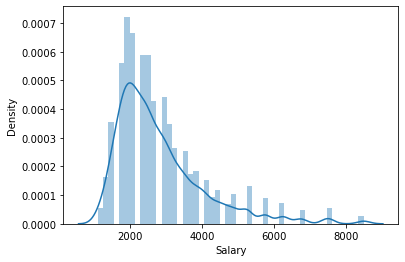

In [7]:
sns.distplot(y_train); plt.show() 

#### 수치형/범주형 피처 분리 & 학습/평가 데이터 분할

In [8]:
numeric_features = ['대학성적']
categorical_features = ['직종','세부직종','직무태그','근무경력','근무형태','근무지역','출신대학','대학전공','어학시험','자격증']

X_train = X_train[numeric_features+categorical_features]  # 순서 주의!!!
X_test = X_test[numeric_features+categorical_features]

####  파이프라인 구축

In [9]:
def remove_outlier(X, q=0.05):  
    df = pd.DataFrame(X)
    return df.apply(lambda x: x.clip(x.quantile(q), x.quantile(1-q)), axis=0).values

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("outlier", FunctionTransformer(remove_outlier, kw_args={'q':0.05})), #kw_args : 어디까지 잘리는 거냐구
        ("scaler", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=True)),
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer), 
        ("selector", SelectPercentile(percentile=100)),
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", Ridge(alpha=1.0)), #alpha값 작아질수록 과적합 가능성 높아짐
    ]
)

set_config(display="diagram")  # To view the text pipeline, change to display='text'.
model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('column',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('outlier',
                                                                                    FunctionTransformer(func=<function remove_outlier at 0x0000027C556614C0>,
                                                                                                        kw_args={'q': 0.05})),
                                                                                   ('scaler',
                                                                                    PowerTransformer())]),
                                                                   ['대학성적']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['직종',
                                                                    '세부직종',
                                                                    '직무태그',
                                                                    '근무경력',
                                                                    '근무형태',
                                                                    '근무지역',
                                                                    '출신대학',
                                                                    '대학전공',
                                                                    '어학시험',
                                                                    '자격증'])])),
                                 ('selector',
                                  SelectPercentile(percentile=100))])),
                ('classifier', Ridge())])

#### LM Baseline 성능 확인

In [10]:
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
# cross_val_score는 무조건 값이 크면 클수록 좋다고 판단.
# 때문에 neg_mse를 사용하여 mse 앞에 -를 붙여서 절댓값이 작은 수가 출력되도록!

print("Default LM CV scores: ", np.sqrt(-1*scores))
print("Default LM CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))

# 평가지표 RMSE

Default LM CV scores:  [ 839.69400327  808.78072379  905.51525037  945.11111326 1101.33295126]
Default LM CV mean = 925.78 with std = 443.60


#### `파이프라인+Optuna`를 통한 LM 하이퍼파라미터 최적화

In [11]:
%%time

param_distributions = {
    "preprocessor__column__num__imputer__strategy": CategoricalDistribution(["mean","median"]),
    "preprocessor__column__num__outlier__kw_args": CategoricalDistribution([{'q':0.01},{'q':0.05},{'q':0.1}]),  
    "preprocessor__selector__percentile": IntDistribution(50,100,step=10), 
    "classifier__alpha": IntDistribution(1,10),
}

optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_search = OptunaSearchCV(model, param_distributions, cv=5, 
                               scoring='neg_mean_squared_error', n_trials=20,
                               study=optuna.create_study(sampler=optuna.samplers.TPESampler(seed=100), direction='maximize'))
optuna_search.fit(X_train, y_train)

Wall time: 19.5 s


OptunaSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                          Pipeline(steps=[('column',
                                                           ColumnTransformer(transformers=[('num',
                                                                                            Pipeline(steps=[('imputer',
                                                                                                             SimpleImputer(strategy='median')),
                                                                                                            ('outlier',
                                                                                                             FunctionTransformer(func=<function remove_outlier at 0x0000027C556614C0>,
                                                                                                                                 kw_args={'q': 0.05})),
                                                                                                            ('scaler',
                                                                                                             PowerTransformer())]),
                                                                                            ['대학성적']),
                                                                                           ('cat',
                                                                                            Pipeline(steps=[...
                                    'preprocessor__column__num__imputer__strategy': CategoricalDistribution(choices=('mean', 'median')),
                                    'preprocessor__column__num__outlier__kw_args': CategoricalDistribution(choices=({'q': 0.01}, {'q': 0.05}, {'q': 0.1})),
                                    'preprocessor__selector__percentile': IntDistribution(high=100, log=False, low=50, step=10)},
               scoring='neg_mean_squared_error',
               study=<optuna.study.study.Study object at 0x0000027C560AA520>)

In [12]:
print(f"\nBest params: {optuna_search.best_params_}")
print(f"\nBest score: {np.sqrt(-1*optuna_search.best_score_):.2f}")

#alpha가 4일 때 잘 나왔다 = 과적합이 심하다는 뜻
#tuning 해보니 최적 파라미터가 바뀜


Best params: {'preprocessor__column__num__imputer__strategy': 'median', 'preprocessor__column__num__outlier__kw_args': {'q': 0.01}, 'preprocessor__selector__percentile': 90, 'classifier__alpha': 4}

Best score: 915.65


#### Submission 생성

In [12]:
# 최적화된 하이퍼파라미터로 파이프라인 재설정
model.set_params(**optuna_search.best_params_)

# cross validation을 돌려서 5번 돌리기 => 5개의 모델이 생기는 셈 (파라미터는 똑같은데 학습 데이터가 바뀜)
# 5개의 평가치를 모두 1/5로 평균 낸다
 
# OOF Prediction (kaggle에서 많이 쓰는 방식!)
models = cross_validate(model, 
                        X_train, y_train, 
                        cv=5, 
                        scoring='neg_mean_squared_error', 
                        return_estimator=True)
oof_pred = np.array([m.predict(X_test) for m in models['estimator']]).mean(axis=0)

scores = models['test_score']
print("\nTuned LM CV scores: ", np.sqrt(-1*scores))
print("Tuned LM CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))


Tuned LM CV scores:  [ 819.94352263  792.65472856  890.39485316  942.44087148 1100.22612704]
Tuned LM CV mean = 915.65 with std = 455.24


In [13]:
# submission 화일 생성
filename = f'LM_{LM_VERSION}_{np.sqrt(-1*scores.mean()):.2f}.csv'
pd.DataFrame({'ID':test_id, 'Salary':oof_pred}).to_csv(filename, index=False)

<font color="#CC3D3D"><p>
# End